## Import Dataset

In [ ]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!echo '{"username":"rohitawate","key":"14a69194fa4cd4e37490796b1f37ff69"}' > ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kartik2112/fraud-detection

 99% 200M/202M [00:01<00:00, 183MB/s]
100% 202M/202M [00:01<00:00, 174MB/s]


In [ ]:
!unzip fraud-detection.zip

Archive:  fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('fraudTrain.csv')

## Dropping columns

In [ ]:
df.columns
df.drop(['trans_num', 'street', 'first', 'last', 'gender', 'unix_time'], axis=1, inplace=True)

In [ ]:
df['merchant'] = df['merchant'].apply(lambda name : name.replace("fraud_", ""))
df['merchant']

0                   Rippin, Kub and Mann
1              Heller, Gutmann and Zieme
2                         Lind-Buckridge
3           Kutch, Hermiston and Farrell
4                          Keeling-Crist
                       ...              
1296670                      Reichel Inc
1296671               Abernathy and Sons
1296672                   Stiedemann Ltd
1296673    Reinger, Weissnat and Strosin
1296674    Langosh, Wintheiser and Hyatt
Name: merchant, Length: 1296675, dtype: object

In [ ]:
df['category'].unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

In [ ]:
# Source: https://stackoverflow.com/a/29546836/6948907

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
df['distance_bet_user_merchant'] = haversine_np(df['lat'],df['long'],df['merch_lat'],df['merch_long'])
df['distance_bet_user_merchant'] # km

0          96.708914
1          14.491400
2          42.453757
3          60.187449
4          92.438680
             ...    
1296670    94.799613
1296671    82.264863
1296672    79.105773
1296673    79.038475
1296674    47.604840
Name: distance_bet_user_merchant, Length: 1296675, dtype: float64

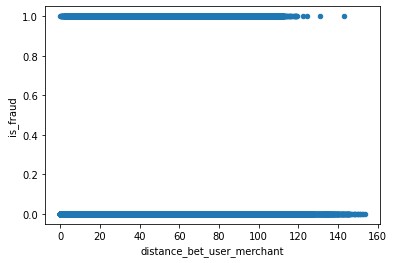

In [ ]:
df.plot.scatter(x='distance_bet_user_merchant', y='is_fraud')

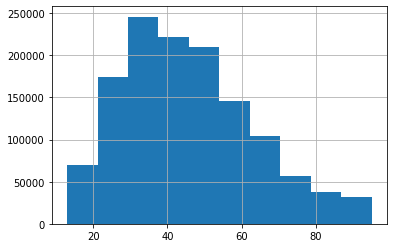

In [ ]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])
df['user_age'] = (df['trans_date_trans_time'] - df['dob']).astype('<m8[Y]')
df['user_age'].hist()

In [ ]:
def is_weekend(txn_time):
    return int(txn_time.weekday() >= 5)

def is_night(txn_time):
    return int(txn_time.hour <= 6 or txn_time.hour >= 22)

In [ ]:
df['txn_at_night'] = df['trans_date_trans_time'].apply(lambda txn_time: is_night(txn_time))
df['txn_on_weekend'] = df['trans_date_trans_time'].apply(lambda txn_time: is_weekend(txn_time))
df[['txn_at_night', 'txn_on_weekend']]

,txn_at_night,txn_on_weekend
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
1296670,0,1
1296671,0,1
1296672,0,1
1296673,0,1


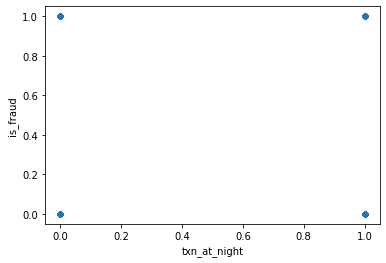

In [ ]:
df.plot.scatter(x='txn_at_night', y='is_fraud')

In [ ]:
df['category'].shape

(1296675,)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
ohe_df = pd.DataFrame(encoder.fit_transform(df['category'].values.reshape(-1, 1)).toarray())

In [ ]:
cat_dict = [None] * 14

for i in range(14):
  cat_dict[i] = f"cat_{i}"

ohe_df.columns = cat_dict
ohe_df

,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10,cat_11,cat_12,cat_13
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296671,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296672,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296673,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df.join(ohe_df)
df.drop(['category'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df['merchant_oe'] = encoder.fit_transform(df['merchant'].values.reshape(-1, 1)).ravel()
df.drop(['merchant'], axis=1, inplace=True)

In [ ]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,amt,city,state,zip,lat,long,city_pop,...,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10,cat_11,cat_12,cat_13,merchant_oe
0,0,2019-01-01 00:00:18,2703186189652095,4.97,Moravian Falls,NC,28654,36.0788,-81.1781,3495,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,514.0
1,1,2019-01-01 00:00:44,630423337322,107.23,Orient,WA,99160,48.8878,-118.2105,149,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,241.0
2,2,2019-01-01 00:00:51,38859492057661,220.11,Malad City,ID,83252,42.1808,-112.2620,4154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,390.0
3,3,2019-01-01 00:01:16,3534093764340240,45.00,Boulder,MT,59632,46.2306,-112.1138,1939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360.0
4,4,2019-01-01 00:03:06,375534208663984,41.96,Doe Hill,VA,24433,38.4207,-79.4629,99,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,297.0


In [ ]:
encoder = OrdinalEncoder()
df['city_oe'] = encoder.fit_transform(df['city'].values.reshape(-1, 1)).ravel()

encoder = OrdinalEncoder()
df['state_oe'] = encoder.fit_transform(df['state'].values.reshape(-1, 1)).ravel()

encoder = OrdinalEncoder()
df['job_oe'] = encoder.fit_transform(df['job'].values.reshape(-1, 1)).ravel()

In [ ]:
df.drop(['city', 'state', 'trans_date_trans_time', 'dob', 'job'], axis=1, inplace=True)

In [ ]:
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,cc_num,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,distance_bet_user_merchant,...,cat_8,cat_9,cat_10,cat_11,cat_12,cat_13,merchant_oe,city_oe,state_oe,job_oe
0,2703186189652095,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,0,96.708914,...,1.0,0.0,0.0,0.0,0.0,0.0,514.0,526.0,27.0,370.0
1,630423337322,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,0,14.491400,...,0.0,0.0,0.0,0.0,0.0,0.0,241.0,612.0,47.0,428.0
2,38859492057661,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,0,42.453757,...,0.0,0.0,0.0,0.0,0.0,0.0,390.0,468.0,13.0,307.0
3,3534093764340240,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,0,60.187449,...,0.0,0.0,0.0,0.0,0.0,0.0,360.0,84.0,26.0,328.0
4,375534208663984,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,0,92.438680,...,0.0,1.0,0.0,0.0,0.0,0.0,297.0,216.0,45.0,116.0


In [ ]:
y = df['is_fraud']
df.drop(['is_fraud'], axis=1, inplace=True)

In [ ]:
df.drop(['cc_num'], axis=1, inplace=True)

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=500, class_weight={0:1,1:75})
classifier.fit(df, y)

LogisticRegression(class_weight={0: 1, 1: 75}, max_iter=500)

In [ ]:
from sklearn.metrics import confusion_matrix
print(classifier.score(df, y))
results = confusion_matrix(y, classifier.predict(df))
results

0.9779520697167756


array([[1263156,   26013],
       [   2576,    4930]])

In [ ]:
df.columns

Index(['amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
       'distance_bet_user_merchant', 'user_age', 'txn_at_night',
       'txn_on_weekend', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5',
       'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11', 'cat_12',
       'cat_13', 'merchant_oe', 'city_oe', 'state_oe', 'job_oe'],
      dtype='object')

In [ ]:
df['distance_bet_user_merchant'].describe()

count    1.296675e+06
mean     5.815857e+01
std      3.092709e+01
min      1.575705e-02
25%      3.160839e+01
50%      5.775650e+01
75%      8.476890e+01
max      1.534359e+02
Name: distance_bet_user_merchant, dtype: float64